# Predict Drug Activity for Androgen Receptor

Adapted from Tomasz K. Piskorz. [Predict Drug activity for androgen receptor](https://github.com/tkpiskorz/cheminformatics_notebooks/blob/master/AR/Androgen%20receptor.ipynb).

## Overview

This tutorial demonstrates how to use machine learning algorithms to predict drug activity for androgen receptor using Quantitative Structure–Property Relationship (QSPR) descriptors. The analysis uses the Tox21 dataset and molecular descriptors calculated using the `mordred` package to build predictive models.

This tutorial uses a couple of packages we have not yet seen. You can learn more about them here:

- RDKit: a Python [Open-Source Cheminformatics Software](https://www.rdkit.org/).
- mordred: a python [molecular descriptor calculator](https://github.com/mordred-descriptor/mordred) package.

## Learning Objectives

- Learn how to work with chemical structure data using RDKit and `mordred`
- Understand how to calculate and use molecular descriptors for drug activity prediction
- Build and evaluate machine learning models for drug activity classification
- Interpret model performance using ROC AUC scores and accuracy metrics

### Tasks to complete

Load and preprocess Tox21 dataset
Calculate molecular descriptors using mordred
Train and evaluate Random Forest model
Train and evaluate Neural Network model
Compare model performances

## Prerequisites

- A working Python environment and familiarity with Python
- Basic understanding of machine learning concepts
- Familiarity with pandas and numpy libraries
- Knowledge of basic statistical concepts


## Get Started

- Please select kernel "conda_tensorflow2_p310" from SageMaker notebook instance.


## Import necessary libraries

\*Note: You may get a deprecation warning regarding `IPython.core.display`. This shouldn't affect the results of the notebook.


In [37]:
# Install the mordredcommunity library version 2.0.6 using pip package manager.
%pip install mordredcommunity==2.0.6

Note: you may need to restart the kernel to use updated packages.


In [38]:
# Import the NumPy library for numerical operations, often used for array manipulation and mathematical functions.
import numpy as np
# Import the Pandas library for data manipulation and analysis, particularly for working with DataFrames.
import pandas as pd
# Import the display function from IPython.display to enable rich outputs like DataFrames in notebooks.
from IPython.display import display
# Import the Calculator class and the descriptors module from the mordred library. Mordred is used for molecular descriptor calculation.
from mordred import Calculator, descriptors
# Import the Missing class from mordred.error to handle missing descriptor values.
from mordred.error import Missing
# Import the Chem module from RDKit, which is the core module for chemical informatics tasks like molecule handling.
from rdkit import Chem

# Import PandasTools from rdkit.Chem. This module enhances Pandas DataFrames to work seamlessly with RDKit molecules.
# It allows you to store and manipulate RDKit molecules directly within DataFrame columns.
from rdkit.Chem import PandasTools
# Import IPythonConsole from rdkit.Chem.Draw to enable the display of molecule images directly in IPython environments like Jupyter notebooks.
from rdkit.Chem.Draw import IPythonConsole
# Import the RandomForestClassifier from sklearn.ensemble. This is a machine learning model used for classification tasks.
from sklearn.ensemble import RandomForestClassifier
# Import the roc_auc_score function from sklearn.metrics to evaluate the performance of classification models, specifically using the Area Under the ROC Curve metric.
from sklearn.metrics import roc_auc_score
# Import the train_test_split function from sklearn.model_selection to split datasets into training and testing sets for model evaluation.
from sklearn.model_selection import train_test_split
# Import the MLPClassifier from sklearn.neural_network. This is a Multi-layer Perceptron classifier, a type of neural network used for classification.
from sklearn.neural_network import MLPClassifier

## _Toxicology in the 21st Century_ (Tox21) Dataset

The _Toxicology in the 21st Century_ (Tox21) initiative created a public database measuring toxicity of compounds, which has been used in the 2014 Tox21 Data Challenge. This dataset contains qualitative toxicity measurements for 8k compounds on 12 different targets, including nuclear receptors and stress response pathways.

The data file contains a csv table, in which columns below are used:

- "smiles" - SMILES representation of the molecular structure
- "NR-XXX" - Nuclear receptor signaling bioassays results
  - [AR](https://pubchem.ncbi.nlm.nih.gov/bioassay/743040): qHTS assay to identify small molecule agonists of the androgen receptor (AR) signaling pathway using the MDA cell line.
  - [AhR](https://pubchem.ncbi.nlm.nih.gov/bioassay/743122): qHTS assay to identify small molecule that activate the aryl hydrocarbon receptor (AhR) signaling pathway.
  - [AR-LBD](https://pubchem.ncbi.nlm.nih.gov/bioassay/74353): qHTS assay to identify small molecule agonists of the androgen receptor (AR) signaling pathway.
- [ER](https://pubchem.ncbi.nlm.nih.gov/bioassay/743079): qHTS assay to identify small molecule agonists of the estrogen receptor alpha (ER-alpha) signaling pathway using the BG1 cell line.
- [ER-LBD](https://pubchem.ncbi.nlm.nih.gov/bioassay/743077): qHTS assay to identify small molecule agonists of the estrogen receptor alpha (ER-alpha) signaling pathway.
- [aromatase](https://pubchem.ncbi.nlm.nih.gov/bioassay/743139): qHTS assay to identify aromatase inhibitors.
- [PPAR-gamma](https://pubchem.ncbi.nlm.nih.gov/bioassay/743140): qHTS assay to identify small molecule agonists of the peroxisome proliferator-activated receptor gamma (PPARg) signaling pathway.

- "SR-XXX" - Stress response bioassays results
  - [ARE](https://pubchem.ncbi.nlm.nih.gov/bioassay/743219): qHTS assay for small molecule agonists of the antioxidant response element (ARE) signaling pathway.
  - [ATAD5](https://pubchem.ncbi.nlm.nih.gov/bioassay/720516): qHTS assay for small molecules that induce genotoxicity in human embryonic kidney cells expressing luciferase-tagged ATAD5.
  - [HSE](https://pubchem.ncbi.nlm.nih.gov/bioassay/743228): qHTS assay for small molecule activators of the heat shock response signaling pathway.
  - [MMP](https://pubchem.ncbi.nlm.nih.gov/bioassay/720637): qHTS assay for small molecule disruptors of the mitochondrial membrane potential.
  - [p53](https://pubchem.ncbi.nlm.nih.gov/bioassay/720552): qHTS assay for small molecule agonists of the p53 signaling pathway.

Please refer to the links at https://tripod.nih.gov/tox21/challenge/data.jsp for details.

### References

Tox21 Challenge. https://tripod.nih.gov/tox21/challenge/


### Load Tox21 dataset


In [39]:
# Reads the tox21.csv file from the "../../Data/" directory into a pandas DataFrame called 'df'.
df = pd.read_csv("../../Data/tox21.csv")

In [40]:
# Display the first 10 rows of the DataFrame 'df' to get a quick overview of the data.
df.head(10)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,TOX5110,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX6619,O=S(=O)(Cl)c1ccccc1
7,0.0,NaN,0.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0,TOX25232,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX22514,OC[C@H](O)[C@@H](O)[C@H](O)CO
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX22517,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]


In [41]:
# Show descriptive summary statistics for the DataFrame 'df'.
# This will include count, mean, std, min, 25%, 50%, 75%, max for numerical columns.
# For categorical columns, it will include count, unique, top, and freq.
df.describe()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
count,7265.000000,6758.000000,6549.000000,5821.000000,6193.000000,6955.000000,6450.000000,5832.000000,7072.000000,6467.000000,5810.000000,6774.000000
mean,0.042533,0.035070,0.117270,0.051538,0.128048,0.050324,0.028837,0.161523,0.037330,0.057523,0.158003,0.062445
std,0.201815,0.183969,0.321766,0.221110,0.334170,0.218627,0.167362,0.368044,0.189583,0.232857,0.364776,0.241979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# Get column names of the DataFrame 'df' and convert them to a list.
list(df.columns)

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53',
 'mol_id',
 'smiles']

In [43]:
# Selects only the columns 'NR-AR' and 'smiles' from the DataFrame 'df'.
df = df[["NR-AR", "smiles"]]
# Displays the first few rows of the DataFrame 'df' with the selected columns.
df.head()

,NR-AR,smiles
0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O


In [44]:
# Get the shape of the DataFrame 'df' (number of rows and columns).
df.shape

(7831, 2)

In [45]:
# Converts the molecules contained in the column "smilesCol" to RDKit molecule objects and adds them to the DataFrame "df".
# This function also allows for the optional computation and storage of molecular fingerprints to speed up substructure searching.
from rdkit import RDLogger

# Suppress RDKit warnings to keep the output cleaner.
RDLogger.DisableLog('rdApp.warning')  # Disables RDKit warning messages.
RDLogger.DisableLog('rdApp.error')    # Disables RDKit error messages as well (optional, but good for cleaner output).

PandasTools.AddMoleculeColumnToFrame(df, smilesCol="smiles") # Uses PandasTools to add a new column of RDKit molecule objects to the DataFrame 'df'. The molecules are created from the SMILES strings in the column named "smiles".
df.head() # Displays the first few rows of the DataFrame 'df' to show the newly added molecule column.

,NR-AR,smiles,ROMol
0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,<rdkit.Chem.rdchem.Mol object at 0x7f976ab7bba0>
1,0.0,CCN1C(=O)NC(c2ccccc2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7f976ab7bc10>
2,NaN,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,<rdkit.Chem.rdchem.Mol object at 0x7f976ab7ba50>
3,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,<rdkit.Chem.rdchem.Mol object at 0x7f976ab7bc80>
4,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7f976ab7bcf0>


In [46]:
# Remove rows from the DataFrame 'df' where the 'ROMol' column contains missing values (NaN).
df = df[~df["ROMol"].isnull()]
# Remove rows from the DataFrame 'df' where the 'NR-AR' column contains missing values (NaN).
df = df[~df["NR-AR"].isnull()]
# Print the shape (number of rows and columns) of the DataFrame 'df' after removing rows with missing values.
df.shape

(7258, 3)

We can see 566 rows with missing values (NaN) are removed.


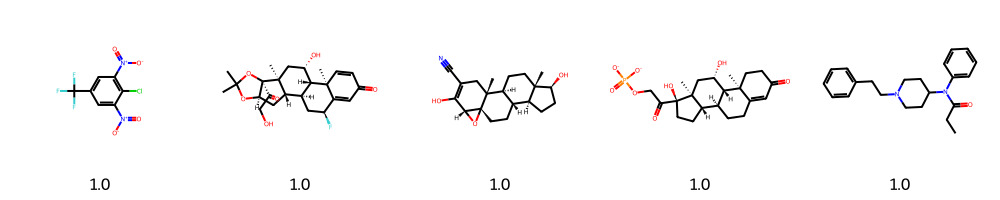

In [47]:
# Use RDKit PandasTools to generate a grid image of molecules from a Pandas DataFrame.
display(
    PandasTools.FrameToGridImage(
        # Filter the DataFrame 'df' to select rows where the 'NR-AR' column is equal to 1.
        df[df["NR-AR"] == 1].head(5),
        # Specify that the 'NR-AR' column should be used to generate legends for each molecule in the grid.
        legendsCol="NR-AR",
        # Set the number of molecules to be displayed in each row of the grid to 5.
        molsPerRow=5
    )
)

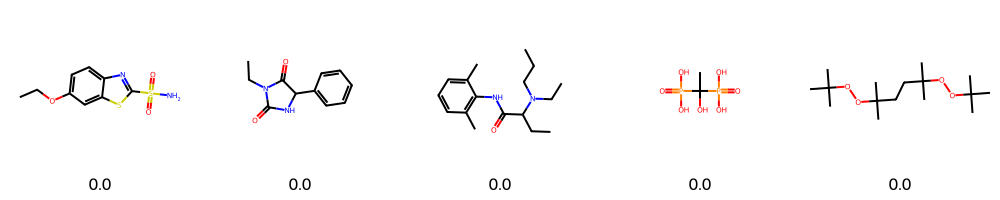

In [48]:
# Display a grid image of molecules from a Pandas DataFrame where the 'NR-AR' column is equal to 0.
display(
    PandasTools.FrameToGridImage(
        # Filter the DataFrame 'df' to include only rows where the 'NR-AR' column is 0.
        df[df["NR-AR"] == 0].head(5),
        # Specify that the 'NR-AR' column should be used for legends in the grid image.
        legendsCol="NR-AR",
        # Set the number of molecules to display per row in the grid to 5.
        molsPerRow=5
    )
)

In [49]:
# Get the unique values from the 'NR-AR' column of the DataFrame 'df'. This effectively counts the number of distinct elements in that column.
df["NR-AR"].unique()

array([0., 1.])

In [50]:
# Counts the number of non-missing values in the 'NR-AR' column of the DataFrame 'df'.
df["NR-AR"].count()

7258

In [51]:
# Calculate and return the sum of the values in the 'NR-AR' column of the DataFrame 'df'.
df["NR-AR"].sum()

308.0

## What is a molecular descriptor?

Molecular descriptors can be defined as mathematical representations of molecules’ properties that are generated by algorithms. The numerical values of molecular descriptors are used to quantitatively describe the physical and chemical information of the molecules. They can be used to predict the
activity, toxicity, and other properties resulting from the
chemical structures of compounds.


In [52]:
# Create a descriptor calculator object named 'calc' that will compute all descriptors listed in the 'descriptors' variable.
# The argument 'ignore_3D=True' specifies that 3D descriptors should be excluded from the calculation.
calc = Calculator(descriptors, ignore_3D=True)

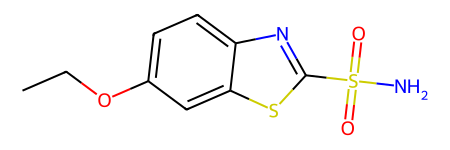

In [53]:
# Accesses the first element of the 'ROMol' column in the DataFrame 'df'.
mol = df["ROMol"][0]
# Displays the 'mol' object, which likely represents a molecule loaded by RDKit.
mol

(The following step may take a few minutes to complete.)


In [54]:
# Uses the 'pandas' method from the 'calc' object to calculate molecular properties for multiple molecules in the 'ROMol' column of DataFrame 'df'. Returns the results as a pandas DataFrame named 'df2'.
df2 = calc.pandas(df["ROMol"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7258/7258 [01:15<00:00, 95.62it/s]


In [55]:
# Display the first few rows of the DataFrame 'df2' (by default, it shows the first 5 rows).
df2.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,12.395521,10.847181,0,0,19.462813,2.447713,4.716372,19.462813,1.216426,3.704694,...,9.698614,62.626045,258.013284,9.923588,442,22,84.0,97.0,6.256944,3.444444
1,11.370728,10.500427,0,0,19.28989,2.435261,4.703788,19.28989,1.285993,3.636116,...,9.553433,61.306823,204.089878,7.558884,353,22,76.0,90.0,5.305556,3.444444
3,14.308545,13.613603,0,1,24.388886,2.349426,4.698852,24.388886,1.219444,3.870393,...,9.653808,52.828148,276.220164,5.754587,830,30,92.0,105.0,8.666667,4.861111
4,8.152948,8.723360,4,0,10.363081,2.44949,4.898979,10.363081,0.942098,3.280313,...,9.682903,42.374286,205.974526,10.840765,136,18,56.0,64.0,8.1875,2.125000
5,15.024215,13.976628,0,0,20.871816,2.297773,4.595546,20.871816,1.043591,3.864202,...,9.674640,53.096806,290.245710,5.374921,934,21,98.0,100.0,11.75,4.000000


In [56]:
# Get the shape of the DataFrame df2 (number of rows and columns).
df2.shape

(7258, 1613)

In [57]:
# Initialize an empty list called 'missing' to store column names with missing values.
missing = []
# Iterate through each column name in the DataFrame 'df2'.
for column in df2.columns:
    # Check if any value in the current 'column' is of type 'Missing'.
    # 'df2[column].apply(lambda x: type(x) == Missing)' applies a function to each element in the column.
    # The lambda function checks if the type of the element 'x' is equal to the type 'Missing'.
    # '.any()' returns True if at least one element in the Series is True (i.e., if at least one value is of type 'Missing').
    if (df2[column].apply(lambda x: type(x) == Missing)).any():
        # If the condition in the 'if' statement is True (meaning the column contains at least one 'Missing' value),
        # append the name of the 'column' to the 'missing' list.
        missing.append(column)

In [58]:
# Drop columns with known errored value from the DataFrame 'df2' and assign the result to 'df_new'.
df_new = df2.drop(missing, axis=1)

In [59]:
# Display the first 5 rows of the DataFrame 'df_new' to inspect the data.
df_new.head()

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,12.395521,10.847181,0,0,9,10,26,16,0,0,...,6.861711,9.698614,62.626045,258.013284,9.923588,442,22,84.0,97.0,3.444444
1,11.370728,10.500427,0,0,6,6,27,15,0,0,...,7.002156,9.553433,61.306823,204.089878,7.558884,353,22,76.0,90.0,3.444444
3,14.308545,13.613603,0,1,6,6,48,20,0,0,...,0.000000,9.653808,52.828148,276.220164,5.754587,830,30,92.0,105.0,4.861111
4,8.152948,8.723360,4,0,0,0,19,11,0,0,...,0.000000,9.682903,42.374286,205.974526,10.840765,136,18,56.0,64.0,2.125000
5,15.024215,13.976628,0,0,0,0,54,20,0,0,...,0.000000,9.674640,53.096806,290.245710,5.374921,934,21,98.0,100.0,4.000000


In [60]:
# Returns the shape of the DataFrame 'df_new' as a tuple (number of rows, number of columns).
df_new.shape

(7258, 699)

In [61]:
# Assigns the 'NR-AR' column from the DataFrame 'df' to the variable 'y' as the target variable.
y = df["NR-AR"]

# Assigns the DataFrame 'df_new' to the variable 'X' to be used as the feature matrix (molecular descriptors).
X = df_new

In [62]:
# Split data into 75% training and 25% test sets
# X_train: Features for the training dataset (75% of X).
# X_test: Features for the test dataset (25% of X).
# y_train: Labels for the training dataset (75% of y).
# y_test: Labels for the test dataset (25% of y).
# train_test_split: Function used to split the dataset into training and testing sets.
# X: Features data to be split.
# y: Labels data to be split.
# By default, test_size is 0.25 if not specified, meaning 25% of the data will be used for testing, and 75% for training.
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Random forest

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.


In [63]:
# Import the RandomForestClassifier class from scikit-learn's ensemble module.
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier object with 100 trees (n_estimators=100) and train it using the training data (X_train, y_train).
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

### Receiver Operating Characteristic Curve (ROC AUC)

Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predicted class probabilities

The predicted class probabilities of an input sample are computed as
the mean predicted class probabilities of the trees in the forest.

The class probability of a single tree is the fraction of samples of
the same class in a leaf.


In [64]:
# Calculates the Area Under the Receiver Operating Characteristic Curve (ROC AUC) score.
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.7982999092184535

In [65]:
# Compute the mean accuracy of training data using the classifier 'clf' and training features 'X_train' and labels 'y_train'.
clf.score(X_train, y_train)

0.9992651111519383

In [66]:
# Compute the mean accuracy of the classifier (clf) on the test data (X_test, y_test).
# This method calculates the accuracy by comparing the classifier's predictions for X_test
# against the true labels y_test and returning the mean accuracy score.
clf.score(X_test, y_test)

0.9746556473829201

## Multi-layer Perceptron classifier

This model optimizes the log-loss function using LBFGS or stochastic gradient descent.


In [67]:
# Print the original DataFrame X_train, including rows with missing values (NaN).
print(X_train)

# Print a new DataFrame that is created by removing rows with any missing values (NaN) from X_train.
# This will show X_train with only complete rows, where no values are missing.
print(X_train.dropna())

            ABC      ABCGG  nAcid  nBase  nAromAtom  nAromBond  nAtom  \
3703  18.577646  15.448423      0      1         12         12     47   
2261  10.635111   9.703324      0      1          9         10     30   
2839   5.875634   5.566041      0      0          6          6     16   
4792  11.313708   9.490206      0      0         12         12     25   
3087  18.199514  15.631024      2      0          9         10     37   
...         ...        ...    ...    ...        ...        ...    ...   
4884  12.647042  10.574357      0      3          6          6     33   
4319  14.727922  12.112692      0      0         18         18     34   
5840   2.449490   2.449490      0      0          0          0      4   
4339  17.177412  13.958277      1      0         17         17     34   
2970   8.175294   7.770338      0      0          6          6     20   

      nHeavyAtom  nSpiro  nBridgehead  ...     SRW09      SRW10     TSRW10  \
3703          24       0            0  ...  0

(The following cell may take a few minutes to complete.)


In [68]:
# Import Multi-layer Perceptron classifier from sklearn.neural_network
from sklearn.neural_network import MLPClassifier

# Create a Multi-layer Perceptron classifier instance
# with 6 hidden layers.
# The number of neurons in each hidden layer are specified as a list: [1000, 500, 250, 100, 50, 20].
# Layer 1: 1000 neurons
# Layer 2: 500 neurons
# Layer 3: 250 neurons
# Layer 4: 100 neurons
# Layer 5: 50 neurons
# Layer 6: 20 neurons
clf = MLPClassifier(hidden_layer_sizes=[1000, 500, 250, 100, 50, 20])
# Train the Multi-layer Perceptron classifier model
# using the training data (X_train features and y_train labels).
clf = clf.fit(
    X_train, y_train
)

### Receiver Operating Characteristic Curve (ROC AUC)

Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predicted class probabilities.


In [69]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (ROC AUC score).
# This metric evaluates the performance of the classifier by measuring the area under the ROC curve.
# It uses the true labels (y_test) and the predicted probabilities of the positive class (class '1')
# from the classifier (clf) on the test data (X_test).
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.745794476080438

In [70]:
# Compute the mean accuracy of the classifier 'clf' on the training data (X_train, y_train).
clf.score(X_train, y_train)

0.9612346132647437

In [71]:
# Compute the mean accuracy of the classifier on the test data (X_test, y_test).
clf.score(X_test, y_test)

0.9559228650137741

## Conclusion

This tutorial demonstrated how to:

- Work with chemical structure data using RDKit
- Calculate molecular descriptors using `mordred`
- Build and evaluate machine learning models for predicting drug activity
- Use different model architectures (Random Forest and Neural Networks) for classification tasks
- Assess model performance using ROC AUC scores and accuracy metrics

## Clean up

Remember to shut down your Jupyter Notebook environment and delete any unnecessary files or resources once you've completed the tutorial.
